In [1]:
from pathlib import Path

# Get the current working directory as a Path object
current_path = Path.cwd()
home_folder = 'evan_home'

# Traverse up the directory tree until you find the target folder
for parent in [current_path] + list(current_path.parents):
    if parent.name == home_folder:
        home_path = parent
        break
else:
    raise ValueError(f"Folder '{home_folder}' not found in the current working directory.")

print("Home Path:", home_path)
source_code_dir = home_path / 'Source_code'
dataset_dir = home_path / 'Dataset'


Home Path: c:\Users\evanlee\Documents\Bmi_NAS_evan\evan_home


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import pickle
import xgboost as xgb

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score, matthews_corrcoef
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold


In [4]:
import scanpy as sc

# adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Harmony_noZ\Hao_Harmony_test_no_scale.h5ad")
adata = sc.read_h5ad(dataset_dir / 'PBMC_Hao/GSE164378_Hao/Harmony_noZ/Hao_Harmony_test_no_scale.h5ad')
print('Original adata:', adata.shape)
adata.obs['celltype.l2'] = adata.obs['celltype.l2'].str.replace(' ', '_')
label = adata.obs['celltype.l2'].tolist()
types = np.unique(label).tolist()
print('all cell types:', types)
print('====================')
# del adata


Original adata: (161764, 33538)
all cell types: ['ASDC', 'B_intermediate', 'B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK_CD56bright', 'NK_Proliferating', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC']


In [4]:
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden
L1_AAACCCAAGAAACTCA,Mono,CD14_Mono,CD14 Mono,Batch1,P2,7,L1,G1,7535,217,10823,2915,4
L1_AAACCCAAGACATACA,CD4 T,CD4_TCM,CD4 TCM_1,Batch1,P1,7,L1,G1,6013,209,5864,1617,2
L1_AAACCCACAACTGGTT,CD8 T,CD8_Naive,CD8 Naive,Batch1,P4,2,L1,S,6620,213,5067,1381,5
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,4786,1890,3
L1_AAACCCACAGCATACT,CD8 T,CD8_Naive,CD8 Naive,Batch1,P4,7,L1,G1,6402,215,6505,1621,5


## Read features

In [ ]:
import os
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level2\feature_selection_k3")
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level2/feature_selection_k3')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue

In [6]:
features_dict.keys()

dict_keys(['ASDC', 'B_intermediate', 'B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK_CD56bright', 'NK_Proliferating', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC'])

In [7]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
ASDC,47,25
B_intermediate,96,49
B_memory,170,90
B_naive,9,6
CD14_Mono,29,16
CD16_Mono,37,17
CD4_CTL,122,45
CD4_Naive,730,393
CD4_Proliferating,70,35
CD4_TCM,247,133


## Build classifiers (K-fold CV)

In [8]:
def XGB_kfold(data, all_features_dict, celltype, k=5):
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l2'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    # Initialize the XGBoost classifier, add L2-regularization
    xgb_clf = xgb.XGBClassifier(n_estimators=1000, objective='binary:logistic', eval_metric='logloss', reg_lambda=1, device='cuda')
    # Train the classifier
    xgb_clf.fit(X_train, y_train)

    # Kfold cross validation
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1_score': 'f1',
        'roc_auc': 'roc_auc',
        'average_precision': 'average_precision',  # PR AUC
        'mcc': make_scorer(matthews_corrcoef)
    }

    print('Cross validation...')
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    # cv_results = cross_validate(clf, X, y, cv=cv, scoring=scoring, n_jobs=32)
    ## Use training set in cross_validate()
    cv_results = cross_validate(xgb_clf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=32)

    mean_accuracy = np.mean(cv_results['test_accuracy'])
    mean_precision = np.mean(cv_results['test_precision'])
    mean_recall = np.mean(cv_results['test_recall'])
    mean_f1 = np.mean(cv_results['test_f1_score'])
    mean_auc = np.mean(cv_results['test_roc_auc'])
    mean_pr_auc = np.mean(cv_results['test_average_precision'])
    mean_mcc = np.mean(cv_results['test_mcc'])
    mean_metrics = [mean_accuracy, mean_precision, mean_recall, mean_f1, mean_auc, mean_pr_auc, mean_mcc]

    # likelihood of the positive class for each observation
    # make prediction for all of X
    likelihood_all = xgb_clf.predict_proba(X)[:, 1]  # >0.5: predict celltype, <0.5: predict not celltype
    print('likelihood > 0.5:', sum(likelihood_all > 0.5))  # decision_scores > 0 的有幾個

    return xgb_clf, mean_metrics, cv_results, likelihood_all


In [ ]:
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level2\XGB_model")
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level2/XGB_model')

cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics = pd.DataFrame(columns=cols)
cv_results_dict = {}
likelihood_dict = {}
for celltype in types:
    print('====================')
    print('K-fold CV for:', celltype)
    clf, metrics, cv_results, likelihood = XGB_kfold(adata, features_dict, celltype, k=5)  # metrics is a list
    print(metrics)
    
    # Record CV results fold-by-fold
    cv_results_dict[celltype] = cv_results

    # Append metrics to all_metrics
    all_metrics.loc[celltype] = metrics

    # output XGB model as pickle
    # filename = f'XGBclassifier_{celltype}_l1.pkl'
    # with open(filename, 'wb') as f:
    #     pickle.dump(clf, f)

    likelihood_dict[celltype] = likelihood


K-fold CV for: ASDC
Cross validation...
likelihood > 0.5: 75
[0.9998377268511891, 0.9191919191919192, 0.7217948717948718, 0.808008658008658, 0.999884580694399, 0.9166075743548271, 0.8141475415016373]
K-fold CV for: B_intermediate
Cross validation...
likelihood > 0.5: 2383
[0.99535587949772, 0.8823143936193556, 0.7979434447300772, 0.8377007604069504, 0.998314423399095, 0.917218611342802, 0.8365964551564542]
K-fold CV for: B_memory
Cross validation...
likelihood > 0.5: 3284
[0.997627711641931, 0.9443745365659237, 0.9387434365381134, 0.9414264649840302, 0.9997627377961595, 0.9893345766779719, 0.9402849248119345]
K-fold CV for: B_naive
Cross validation...
likelihood > 0.5: 7739
[0.995162696239406, 0.9468441148165603, 0.9520549347436663, 0.9494264306511344, 0.9993499763859741, 0.9864487182789409, 0.9468990631668674]
K-fold CV for: CD14_Mono
Cross validation...
likelihood > 0.5: 42739
[0.9920254096899399, 0.9806988257719516, 0.9892539244375771, 0.9849568608141894, 0.9989713585658062, 0.99533

In [11]:
all_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
ASDC,0.999838,0.919192,0.721795,0.808009,0.999885,0.916608,0.814148
B_intermediate,0.995356,0.882314,0.797943,0.837701,0.998314,0.917219,0.836596
B_memory,0.997628,0.944375,0.938743,0.941426,0.999763,0.989335,0.940285
B_naive,0.995163,0.946844,0.952055,0.949426,0.999350,0.986449,0.946899
CD14_Mono,0.992025,0.980699,0.989254,0.984957,0.998971,0.995336,0.979550
CD16_Mono,0.995310,0.937195,0.943234,0.940177,0.999370,0.983699,0.937756
CD4_CTL,0.997411,0.918231,0.832987,0.873491,0.998948,0.945719,0.873265
CD4_Naive,0.986925,0.931072,0.949295,0.940091,0.998088,0.984066,0.932812
CD4_Proliferating,0.999714,0.862648,0.687582,0.759436,0.999390,0.883567,0.767065
CD4_TCM,0.974183,0.864409,0.853412,0.858860,0.992668,0.928502,0.844683


In [12]:
!cd

C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level2\XGB_model


In [13]:
all_metrics.to_csv('XGBclassifier_binary_metrics_l2.csv')

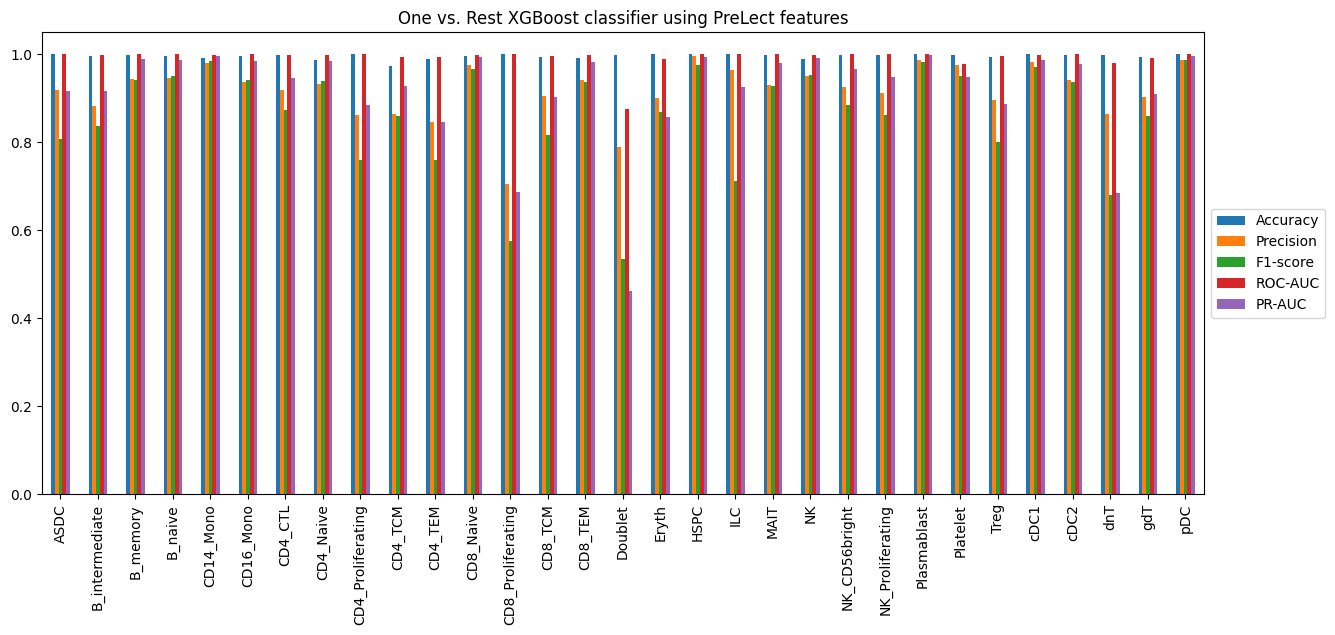

In [15]:
# Plot metrics for each celltype
cols = ['Accuracy', 'Precision', 'F1-score', 'ROC-AUC', 'PR-AUC']
ax = all_metrics[cols].plot.bar(rot=90, figsize=(15,6), title='One vs. Rest XGBoost classifier using PreLect features')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [16]:
# Recursive function to convert np.array to list
def convert_arrays_to_lists(data):
    if isinstance(data, dict):
        return {key: convert_arrays_to_lists(value) for key, value in data.items()}
    elif isinstance(data, np.ndarray):
        return data.tolist()
    else:
        return data

# Convert all np.array elements in the dictionary to lists
dict_converted = convert_arrays_to_lists(cv_results_dict)
dict_converted

{'ASDC': {'fit_time': [7.930733919143677,
   7.936481714248657,
   5.893465280532837,
   7.912295818328857,
   7.930733919143677],
  'score_time': [0.20841121673583984,
   0.2016582489013672,
   0.26567506790161133,
   0.14458727836608887,
   0.19789338111877441],
  'test_accuracy': [0.9997681876134915,
   0.9998840893284908,
   0.9997295417664787,
   0.9998840893284908,
   0.9999227262189939],
  'test_precision': [0.8181818181818182, 1.0, 0.7777777777777778, 1.0, 1.0],
  'test_recall': [0.6923076923076923,
   0.75,
   0.5833333333333334,
   0.75,
   0.8333333333333334],
  'test_f1_score': [0.7500000000000001,
   0.8571428571428571,
   0.6666666666666666,
   0.8571428571428571,
   0.9090909090909091],
  'test_roc_auc': [0.9999286372691862,
   0.9998711506249195,
   0.9999355753124598,
   0.9999710088906067,
   0.9997165313748227],
  'test_average_precision': [0.9130741053817975,
   0.8974358974358974,
   0.8941919191919193,
   0.9642857142857144,
   0.9140502354788069],
  'test_mcc': [

In [17]:
import json
with open('XGBclassifier_KFold_l2.json', 'w') as f:
    json.dump(dict_converted, f)

## Likelihood

In [18]:
# turn likelihood_dict into dataframe
likelihood_df = pd.DataFrame(likelihood_dict)
likelihood_df.head()

,ASDC,B_intermediate,B_memory,B_naive,CD14_Mono,CD16_Mono,CD4_CTL,CD4_Naive,CD4_Proliferating,CD4_TCM,...,NK_CD56bright,NK_Proliferating,Plasmablast,Platelet,Treg,cDC1,cDC2,dnT,gdT,pDC
0,0.000003,8.155765e-10,4.135431e-08,3.012246e-11,9.999896e-01,1.631074e-08,1.599781e-09,6.397612e-11,7.540841e-07,2.447857e-10,...,2.251789e-09,8.455691e-08,6.892861e-07,0.001364,5.244505e-11,0.000002,9.172940e-10,7.673265e-08,2.850786e-10,3.869253e-06
1,0.000002,9.940076e-09,2.743145e-09,2.201980e-10,8.573889e-08,1.008887e-09,3.417014e-08,1.215885e-09,1.126455e-06,9.999988e-01,...,3.515698e-08,3.504604e-08,5.124950e-07,0.000582,8.974581e-07,0.000004,9.099544e-13,1.994421e-06,1.338730e-08,1.161397e-06
2,0.000001,2.453149e-09,5.155372e-08,3.989159e-09,1.347778e-09,4.616202e-10,6.635274e-09,9.633283e-08,1.283125e-06,1.137261e-10,...,1.239581e-07,1.279419e-08,8.360182e-07,0.000078,2.052003e-06,0.000005,1.608462e-12,1.476764e-05,3.268793e-06,2.359849e-07
3,0.000002,3.986385e-08,6.123246e-10,1.166874e-09,2.077463e-08,7.640811e-09,2.362989e-09,1.495344e-09,4.890196e-07,2.542952e-10,...,4.861718e-08,2.506502e-07,8.035233e-07,0.000161,2.462350e-10,0.000004,5.919677e-12,4.379369e-07,1.207243e-04,2.425008e-06
4,0.000002,1.745898e-09,1.130773e-07,1.803164e-10,1.799500e-08,2.622403e-10,1.239735e-07,3.197809e-08,7.573026e-07,1.977451e-11,...,9.892679e-09,4.018516e-08,5.931317e-07,0.001541,6.967763e-07,0.000004,3.889252e-12,3.281138e-05,1.678790e-07,7.524778e-07


In [19]:
likelihood_df.shape

(161764, 31)

In [20]:
# row sum
likelihood_df.sum(axis=1)

0         1.001375
1         1.000599
2         1.000110
3         1.000300
4         1.001598
            ...   
161759    1.000054
161760    0.999993
161761    1.000722
161762    0.991819
161763    1.000045
Length: 161764, dtype: float32

## Assign the celltype with the largest likelihood (no odds ratio)

In [21]:
largest_values = []
largest_columns = []
assignments = []
for index, row in likelihood_df.iterrows():
    # find largest value and their corresponding columns
    largest_value = row.max()
    largest_column = row.idxmax()
    largest_values.append(largest_value)
    largest_columns.append(largest_column)

    assign = largest_column
    assignments.append(assign)

result_df = pd.DataFrame({'Largest Value': largest_values, 'Largest Column': largest_columns, 'Assignment': assignments})
result_df.shape


(161764, 3)

In [22]:
result_df.head(20)

,Largest Value,Largest Column,Assignment
0,0.999990,CD14_Mono,CD14_Mono
1,0.999999,CD4_TCM,CD4_TCM
2,0.999978,CD8_Naive,CD8_Naive
3,1.000000,NK,NK
4,1.000000,CD8_Naive,CD8_Naive
5,0.999998,CD8_TEM,CD8_TEM
6,0.992032,CD16_Mono,CD16_Mono
7,0.999972,B_intermediate,B_intermediate
8,1.000000,NK,NK
9,0.999881,CD8_Naive,CD8_Naive


## Confusion heatmap

In [23]:
import pandas as pd

# Get the true labels
true_labels = adata.obs['celltype.l2'].tolist()

# Get the predicted labels
predicted_labels = result_df['Assignment'].tolist()

# Create the confusion matrix
cm = pd.crosstab(true_labels, predicted_labels, rownames=['True'], colnames=['Predicted'], margins=False)

# reorder columns
# cm = cm.reindex(types + ['Uncertain'], axis=1)

# replace NaN with 0
cm = cm.fillna(0)
cm = cm.astype(int)


In [24]:
cm.to_csv('L2_XGB_likelihood_assignment_conf_matrix.csv')

### Multiclass metrics

In [25]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
accuracy = accuracy_score(true_labels, predicted_labels)
print(accuracy)

0.9936945179397146


In [26]:
method = ['micro', 'macro', 'weighted']
# Micro: Calculate metrics globally by counting the total true positives, false negatives and false positives.
# Macro: Calculate metrics for each label, and find their unweighted mean.
# Weighted: Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance

for m in method:
    precision = precision_score(true_labels, predicted_labels, average=m)
    print(m, precision)

micro 0.9936945179397146
macro 0.9902121671649055
weighted 0.9936903923162478


In [27]:
method = ['micro', 'macro', 'weighted']
# Micro: Calculate metrics globally by counting the total true positives, false negatives and false positives.
# Macro: Calculate metrics for each label, and find their unweighted mean.
# Weighted: Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance

for m in method:
    f1 = f1_score(true_labels, predicted_labels, average=m)
    print(m, f1)

micro 0.9936945179397146
macro 0.9857350960089585
weighted 0.99366305958637


## Plot confusion matrix

In [5]:
import os
# os.chdir('./XGB_model')
cm = pd.read_csv('L2_XGB_likelihood_assignment_conf_matrix.csv', index_col=0)

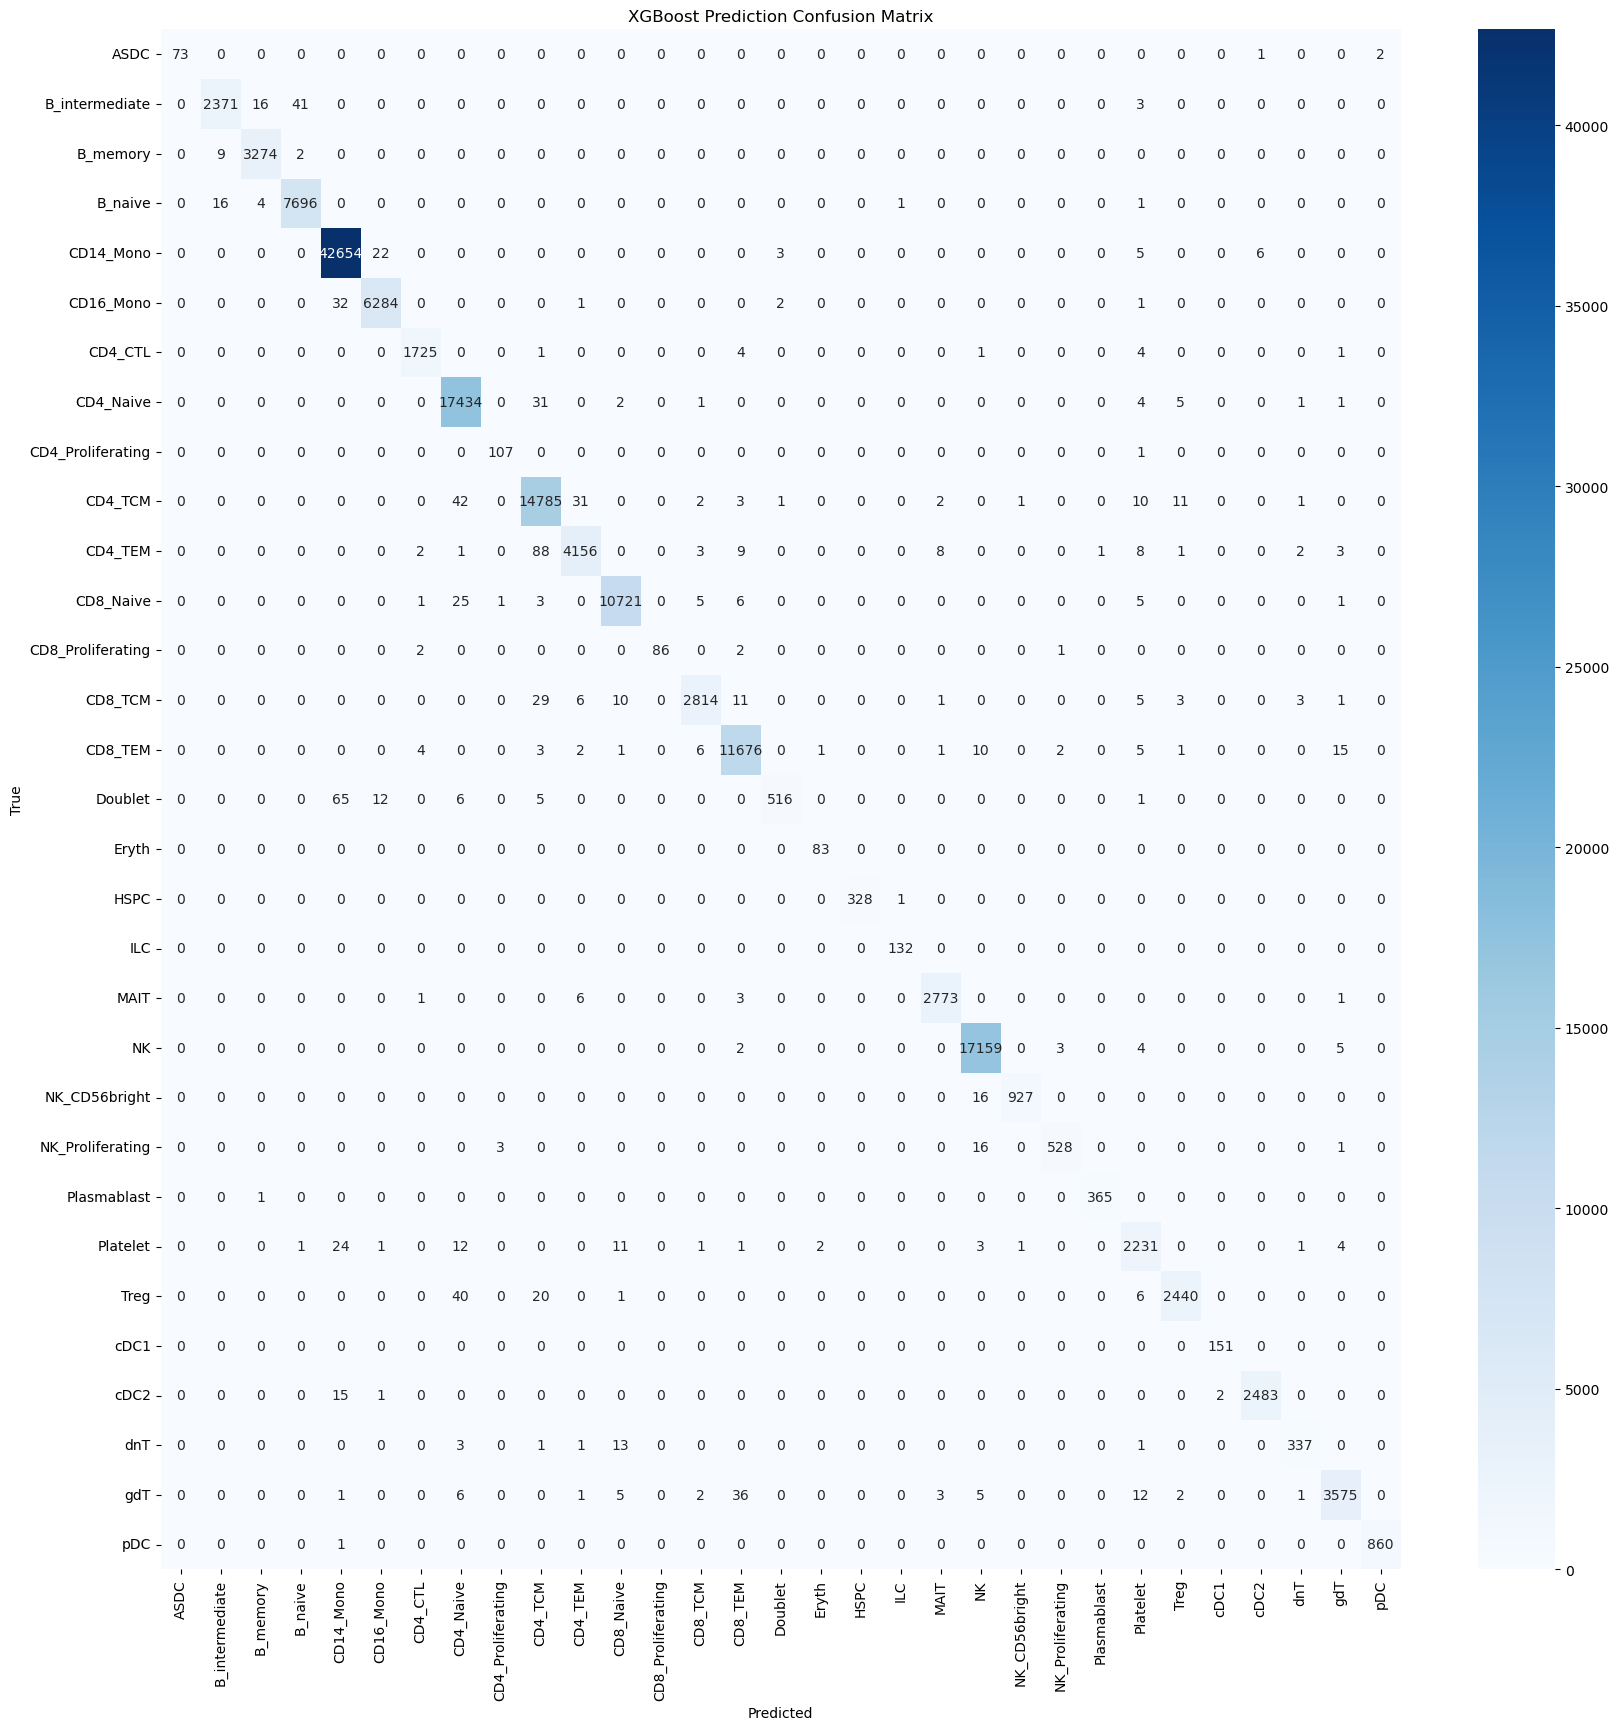

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Prediction Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [8]:
row_sum = cm.sum(axis=1)
row_sum


True
ASDC                    76
B_intermediate        2431
B_memory              3285
B_naive               7718
CD14_Mono            42690
CD16_Mono             6320
CD4_CTL               1736
CD4_Naive            17479
CD4_Proliferating      108
CD4_TCM              14889
CD4_TEM               4282
CD8_Naive            10768
CD8_Proliferating       91
CD8_TCM               2883
CD8_TEM              11727
Doublet                605
Eryth                   83
HSPC                   329
ILC                    132
MAIT                  2784
NK                   17173
NK_CD56bright          943
NK_Proliferating       548
Plasmablast            366
Platelet              2293
Treg                  2507
cDC1                   151
cDC2                  2501
dnT                    356
gdT                   3649
pDC                    861
dtype: int64

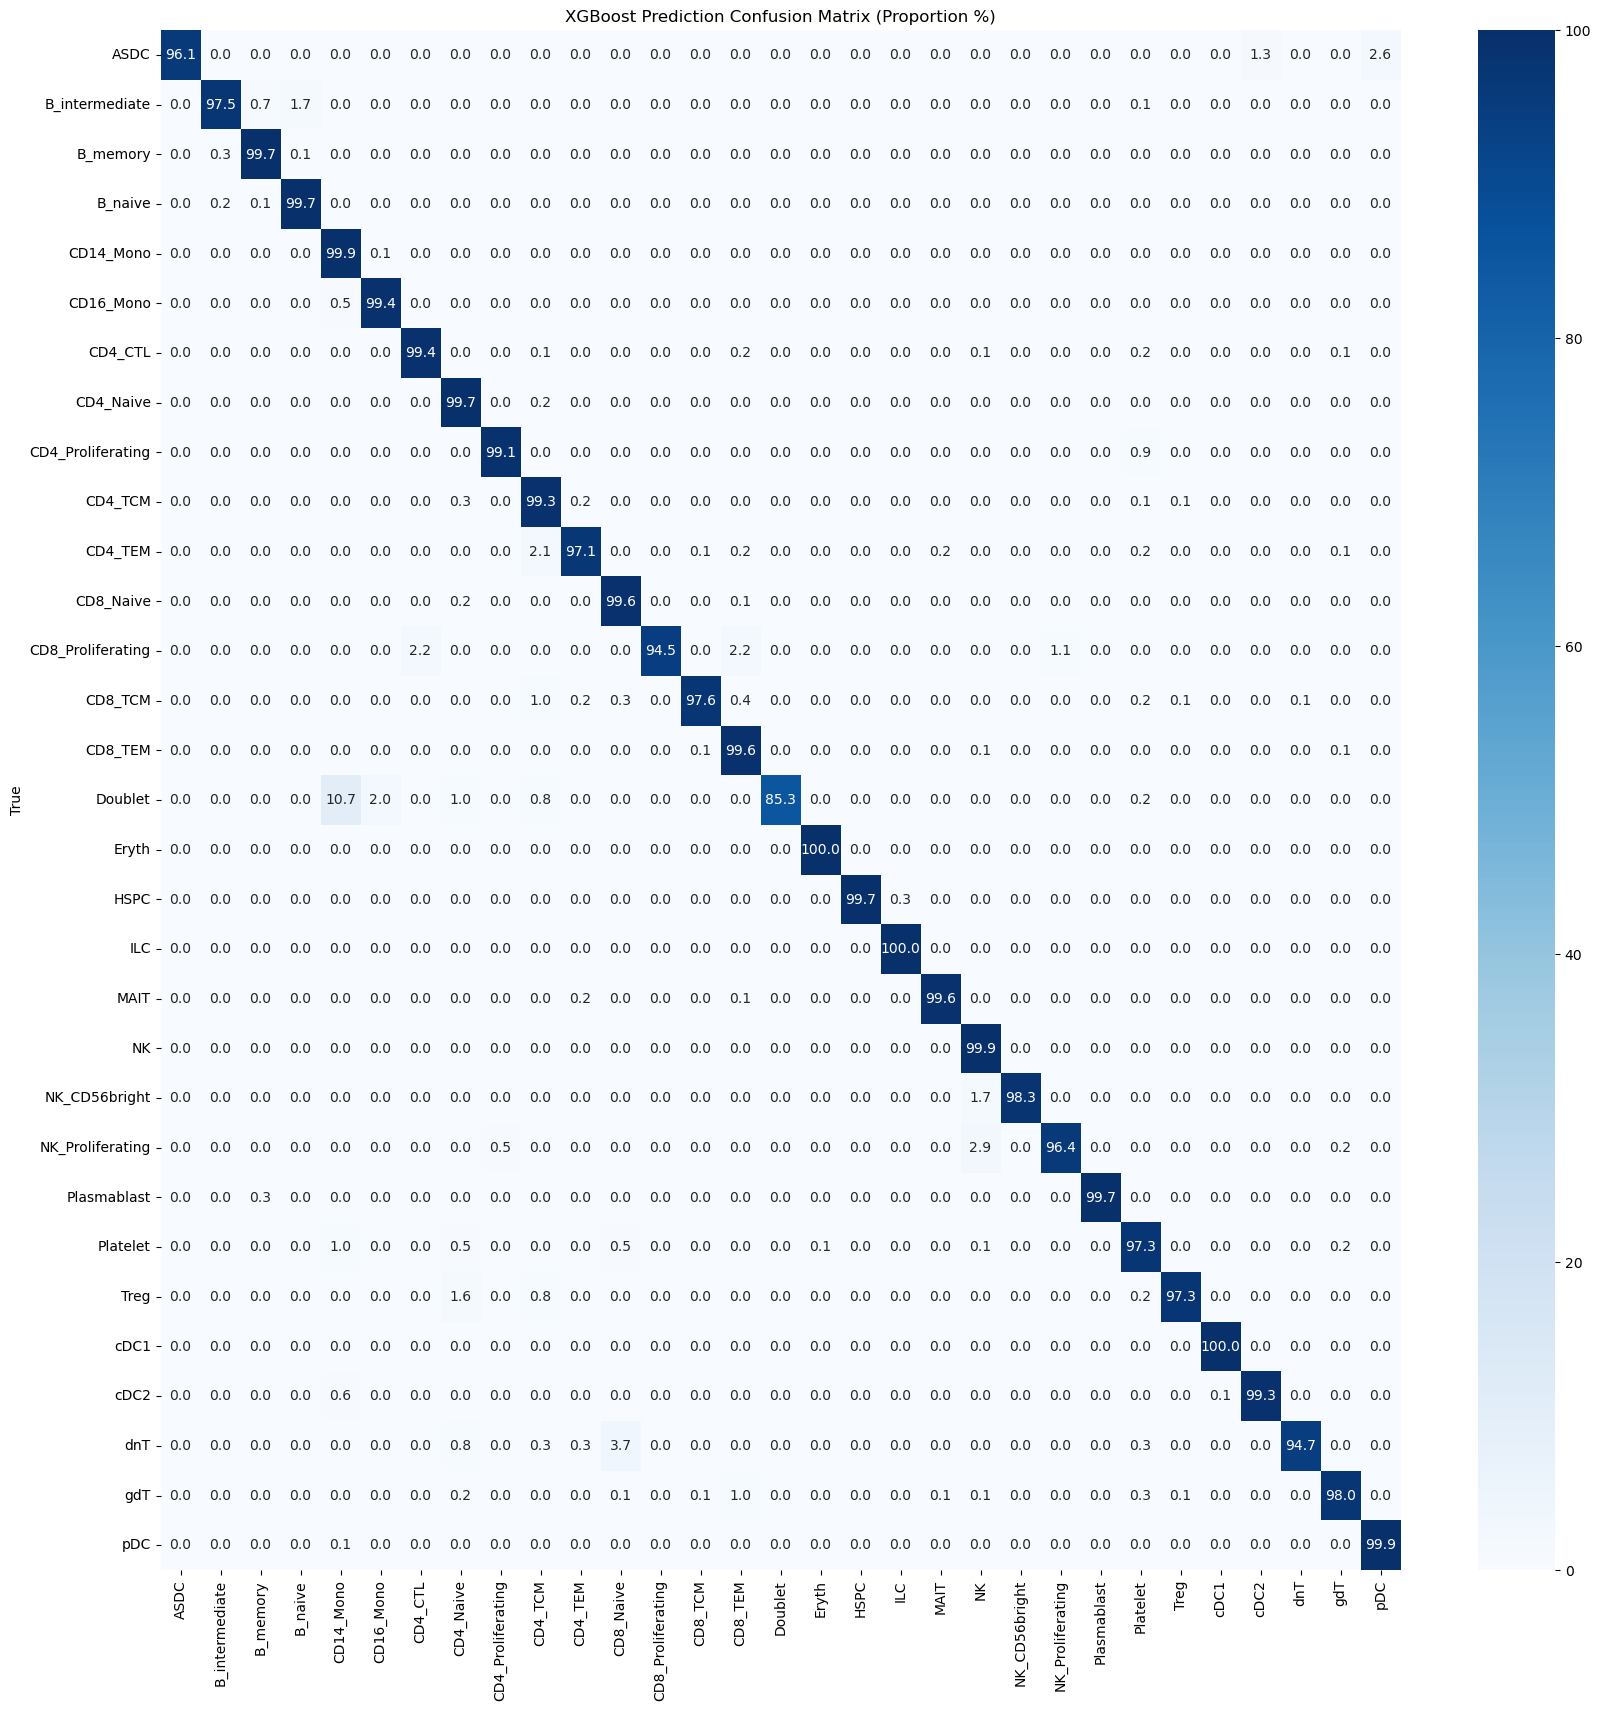

In [9]:
cm_proportion = cm.div(row_sum, axis=0)
cm_proportion *= 100
plt.figure(figsize=(20,20))
sns.heatmap(cm_proportion, fmt=".1f", annot=True, cmap='Blues')
plt.title('XGBoost Prediction Confusion Matrix (Proportion %)')
plt.savefig('cm_plot.png', dpi=300)
plt.show()